In [8]:
from __future__ import division
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import utils

%matplotlib inline

data2d = np.load("data2D.npy").astype(np.float32)
data100d = np.load("data100D.npy").astype(np.float32)

# Split 2D data into training and validation sets
trainsize_2d = int(round(2.0 * data2d.shape[0] / 3.0))
train_2d = data2d[:trainsize_2d,:]
valid_2d = data2d[trainsize_2d:,:]

# Learning rate
LR = 0.1

In [1]:
def euclidean_distance(points, centroids, isSqrt=True):
    '''
    Compute the Euclidean distance from each point to each cluster.
    
    Input:
    - points: a B x D array of D-dimensional points, with B of them
    - centroids: a K x D array of D-dimensional clusters, with K of them
    - isSqrt: bool, whether to transpose and 
            compute the square root before returning or not
    
    Outputs:
    - dists: a B x K matrix of the distances of all points to all centroids
    
    '''
    
    # Prepare for broadcasting
    expanded_points = tf.expand_dims(points, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    
    # Use broadcasting
    square_dists = tf.reduce_sum( tf.square(tf.sub(expanded_points, expanded_centroids)), 2)
    
    # Reshape
    if isSqrt == True:
        # Actual 'distance'
        dists = tf.transpose(tf.sqrt(square_dists))
    else:
        # For (x-mu)^2 computations
        dists = square_dists
    
    return dists


In [2]:
def log_p(points, mus, sigmas, pis):
    '''
    Compute the log P(z=k|x=p) = log sum_normalized_by_k(P(z=k,x=p))
    
    Input:
    - points: a B x D matrix of D-dimensional points, with B of them
    - mus: a K x D matrix of distribution means
    - sigmas: a K x D matrix of distribution VARIANCES
    - pis: a K vector of P(z=k) priors
    
    Outputs:
    - log_p: a K x B matrix of the log probabilities P(z=k|p) for each point p and cluster k
    
    '''
    
    # Get N(x; mu, sigma)
    log_pdfs = log_pdf(points, mus, sigmas) # [K, N]
    
    # Log domain addition is linear domain multiplication
    log_pxz = tf.add(pis, log_pdfs) # [K,N]
    
    # Keep the dimension for broadcasting
    return tf.sub(log_pxz, utils.reduce_logsumexp(log_pxz, 0, keep_dims=True))


In [3]:
def log_pdf(points, mus, sigmas):
    '''
    Compute the log pdf of each cluster k with each point p
    
    Input:
    - points: a B x D matrix of D-dimensional points, with B of them
    - mus: a K x D matrix of distribution means
    - sigmas: a K vector of cluster sigmas
    
    Outputs:
    - log_pdfs: a B x K matrix of log pdfs for each point p and each cluster k
    
    '''

    # Number of clusters - static shapes
    K = mus.get_shape()[0].value
    D = mus.get_shape()[1].value
    
    # Reshape/broadcast tensors
    exp_sigmas = tf.expand_dims(sigmas, 1) # [K,1] 
    
    # The independent dimensions with identical variance condition simplifies computations
    inv_sigmas = tf.inv(exp_sigmas)
    
    # Log domain 
    term1 = D * tf.log(tf.mul(2*np.pi, exp_sigmas)) # [K,1]
    term2 = tf.mul(inv_sigmas, euclidean_distance(points, mus, isSqrt=False)) # [K,1] x [K,B]
    log_pdfs = -tf.mul(0.5, tf.add(term1, term2))
    
    return log_pdfs
    

In [4]:
def mog_learning(data, n_clusters, learning_rate = 0.1, num_epochs=200, show_loss=False):
    '''
    Outputs:
        - Cluster means [n_clusters, n_dims]
        - Cluster variances [n_clusters]
        - Cluster probabilities [n_clusters]
        - Cluster assignments [n_inputs]
        - Loss 
        '''
        
    n_inputs, n_dims = data.shape
    
    # Initialization parameters to determine data scale
    data_mean = np.mean(np.mean(data2d, 0))
    data_var = np.mean(np.var(data2d, 0))
    
    # Placeholders
    points = tf.placeholder("float32", shape=(None, n_dims)) 
    
    # Priors
    init_means = np.random.normal(data_mean, data_var, (n_clusters, n_dims))
    init_phis = np.log(np.random.gamma(2, 1.0/data_var, (n_clusters)))
    init_psis =  np.ones((n_clusters), dtype="float32")
    init_psis = np.log(init_psis/np.linalg.norm(init_psis))
    
    # Variables - initialized with a standard normal distribution
    # Note: sigma = exp(phi), all dimensions of a cluster have the same phi
    cluster_means = tf.Variable(init_means.astype("float32"))
    cluster_phis = tf.Variable(init_phis.astype("float32"))
    cluster_psis = tf.Variable(init_psis.astype("float32"))
    
    # Constrained parameters as functions of unconstrained ones
    cluster_sigmas = tf.exp(cluster_phis)
    logsoft_pis = tf.transpose(utils.logsoftmax(tf.expand_dims(cluster_psis,0)))
    
    # Cost: log-sum-exp picks the maximum along the reduction index
    log_pdfs = log_pdf(points, cluster_means, cluster_sigmas) # [K,N]
    reduced_p = utils.reduce_logsumexp(tf.add(logsoft_pis, log_pdfs), 0) # [N] - sum in log domain
    cost = - tf.reduce_sum(reduced_p, 0) # -log(P(X)) - product in log domain
    
    # Assign each point to the cluster that maximizes P(z|x)
    log_ps = log_p(points, cluster_means, cluster_sigmas, logsoft_pis)
    cluster_assignments = tf.argmax(log_ps, 0)
    
    # Optimizer
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.99, epsilon=0.0001).minimize(cost)
    
    # Initializing the variables
    init = tf.initialize_all_variables()

    # Launch the graphh
    with tf.Session() as sess:
        sess.run(init)
        
        plt.figure(2,figsize=(10,10))
        
        # Initialized k-means
        #print "Initial means:"
        #print cluster_means.eval()
        
        # Training cycle
        for epoch in range(num_epochs):
            loss, _, c_a = sess.run([cost, train_op, cluster_assignments], feed_dict={points : data})
            # Display every few epochs
            if (epoch % 5) == 0:
                if (show_loss == True):
                    #print "Epoch:", '%04d' % (epoch+1)
                    #print loss
                    plt.xlabel("epochs"); plt.ylabel("Loss")
                    plt.plot(epoch, loss,'bo')
                
        plt.show()
        
        c_means = cluster_means.eval()
        c_sigmas = cluster_sigmas.eval()
        c_pis = np.exp(logsoft_pis.eval())
        #c_a = cluster_assignments.eval()
        
        return c_means, c_sigmas, c_pis, c_a, loss
    
def mog_assignment(data, means, sigma, pi):
    n_points, n_dims = data.shape
    n_centroids = means.shape[0]
    
    points = tf.placeholder("float32", shape=(n_points, n_dims)) 
    mus = tf.placeholder("float32", shape=(n_centroids, n_dims)) 
    sigmas = tf.placeholder("float32", shape=(n_centroids)) 
    pis = tf.placeholder("float32", shape=(n_centroids, 1)) 
    
    # Assign each point to the cluster that maximizes P(z|x)
    log_ps = log_p(points, mus, sigmas, pis)
    assignments = tf.argmax(log_ps, 0)
    
    # Cost: log-sum-exp picks the maximum along the reduction index
    log_pdfs = log_pdf(data, mus, sigmas)
    reduced_p = utils.reduce_logsumexp(tf.add(pis, log_pdfs), 0)
    loss = - tf.reduce_sum(reduced_p, 0) # -log(P(X))
    
    # Initializing the variables
    init = tf.initialize_all_variables()

    # Launch the graphh
    with tf.Session() as sess:
        sess.run(init)
        v_ass, v_loss = sess.run([assignments, loss], feed_dict={points : data, mus : means, sigmas : sigma, pis : pi})
        
        return v_ass, v_loss
    

In [5]:
def kmeans_learning(data, n_centroids, num_epochs=200, show_loss = False, give_histogram = False):
    '''
    Outputs:
    - cluster_centroids: [n_centroids, n_dims] centroids
    - ca_output: [n_inputs] cluster assignments
    - loss: float
    - histogram
    '''
    n_inputs, n_dims = data.shape

    # For priors
    data_mean = np.mean(np.mean(data, 0))
    data_var = np.mean(np.var(data,0))
    
    # Placeholders
    points = tf.placeholder("float32", shape=(None, n_dims)) 
    centroid_distances = tf.placeholder("float32", [n_centroids])
    
    # Variables - initialized with a standard normal distribution
    cluster_centroids = tf.Variable(np.random.normal(data_mean, data_var, (n_centroids, n_dims)).astype("float32"))

    # Assign points to closest clusters
    distances = euclidean_distance(points, cluster_centroids) # indexed: [point, cluster id]
    cluster_assignments = tf.argmin(distances, 1)
    
    # Cost and optimizer
    # Sum of distances from each point to its cluster
    cost = tf.reduce_sum( tf.reduce_min(distances, 1) )
    train_op = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=0.0001).minimize(cost)
    
    # Initializing the variables
    init = tf.initialize_all_variables()

    # Number of points in each cluster, normalized and as a percentage
    histogram = np.zeros(n_centroids, np.float32)
    data_size = n_inputs

    # Launch the graphh
    with tf.Session() as sess:
        sess.run(init)
        
        plt.figure(2,figsize=(10,10))
        
        # Training cycle
        for epoch in range(num_epochs):
            loss, _, ca_output = sess.run([cost, train_op, cluster_assignments], feed_dict={points : data})

            # Display every few epochs
            if (epoch % 5) == 0:
                if (show_loss == True):
                    #print "Epoch:", '%04d' % (epoch+1)
                    #print loss
                    plt.xlabel("epochs"); plt.ylabel("Loss")
                    plt.plot(epoch, loss,'bo')
        plt.show()
        cluster_centroids = cluster_centroids.eval()

        if (give_histogram == True):
            for i in range(0, data_size):
                histogram[ca_output[i]] += 1.0

            for i in range(0, n_centroids):
                histogram[i] =  100*histogram[i] / n_inputs
        
        return cluster_centroids, ca_output, loss, histogram
    
def kmeans_assignment(data, centroids):
    n_points, n_dims = data.shape
    n_centroids = centroids.shape[0]
    
    points = tf.placeholder("float32", shape=(n_points, n_dims)) 
    centers = tf.placeholder("float32", shape=(n_centroids, n_dims))
    
    # Assign points to closest clusters
    distances = euclidean_distance(points, centers) # indexed: [point, cluster id]
    assignments = tf.argmin(distances, 1) 
    loss = tf.reduce_sum( tf.reduce_min(distances, 1) )
    
    # Initializing the variables
    init = tf.initialize_all_variables()

    # Launch the graphh
    with tf.Session() as sess:
        sess.run(init)
        v_ass, v_loss = sess.run([assignments, loss], feed_dict={points : data, centers : centroids})
        
        return v_ass, v_loss
    

In [6]:
def plot_clusters(all_samples, centroids, cluster_assignments):
    # Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    plt.figure(2,figsize=(10,10))
    for i, centroid in enumerate(centroids):
        # Grab just the samples for the given cluster and plot them out with a new colour
        samples = []
        for j in range(len(cluster_assignments)):
            if (cluster_assignments[j] == i):
                samples.append(list(all_samples[j]))
        samples = np.asarray(samples, dtype="float32")
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        # Also plot centroid
        plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color='m', mew=5)
    plt.show()

In [ ]:
# Part 1.2.2
cluster_centroids3, cluster_assignments3, _, _ = kmeans_learning(data=data2d, n_centroids=3, num_epochs=200, show_loss = True, give_histogram = True)
plot_clusters(data2d, cluster_centroids3, cluster_assignments3)
print cluster_centroids3

In [ ]:
# Part 1.2.3
for k in range(1,6):
    c_centroids, c_assignments, loss, hist = kmeans_learning(data=data2d, n_centroids=k, num_epochs=200, show_loss = False, give_histogram = True)
    plot_clusters(data2d, c_centroids, c_assignments)

In [ ]:
# Part 1.2.4
for k in range(1, 6):
    c_centroids, train_assignments, train_loss, hist = kmeans_learning(data=train_2d, n_centroids=k, num_epochs=200, show_loss = False, give_histogram = True)
    valid_assignments, valid_loss = kmeans_assignment(valid_2d, c_centroids)
    print "Validation Loss for %d Clusters:" % k, valid_loss

In [ ]:
# MoG Learning
# Part 2.2.2 
c_means, c_sigmas, c_pis, c_a, loss = mog_learning(data=data2d, n_clusters=3, learning_rate=LR, num_epochs=500, show_loss=True)
mog_assignments, _ = mog_assignment(data2d, c_means, c_sigmas, c_pis)
plot_clusters(data2d, c_means, mog_assignments)
print c_means, c_sigmas, c_pis

0.0 0.0 8343.97


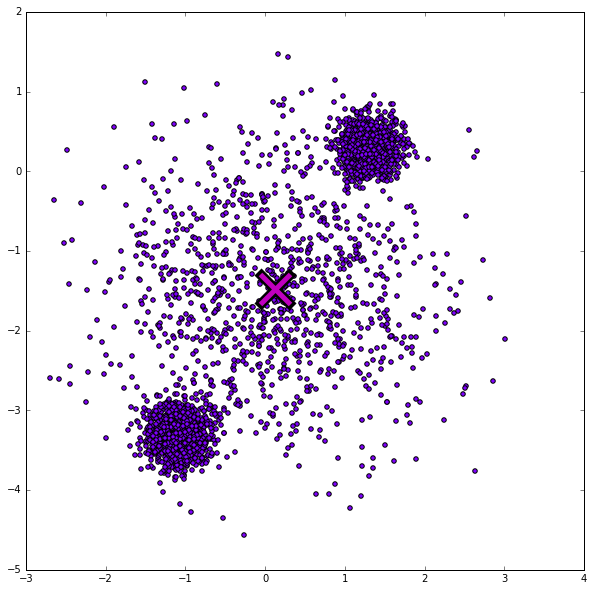

0.346932653367 0.334533453345 4087.65


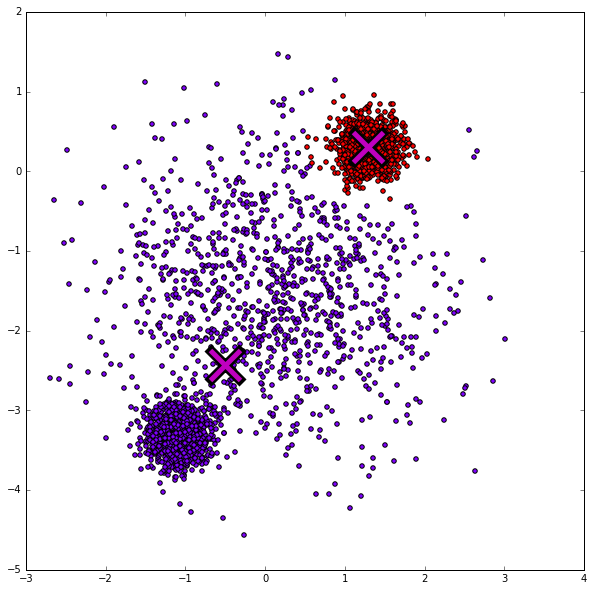

In [10]:
# Part 2.2.3
#np.set_printoptions(threshold=np.nan)
n_epochs=500

for k in range(1, 3):
    c_means, c_sigmas, c_pis, train_assignments, train_loss = mog_learning(data=train_2d, n_clusters=k, learning_rate=LR, num_epochs=n_epochs, show_loss = False)
    valid_assignments, valid_loss = mog_assignment(valid_2d, c_means, c_sigmas, c_pis)
    print valid_loss
    plot_clusters(valid_2d, c_means, valid_assignments)

1.000299985 1.04560456046 805.68


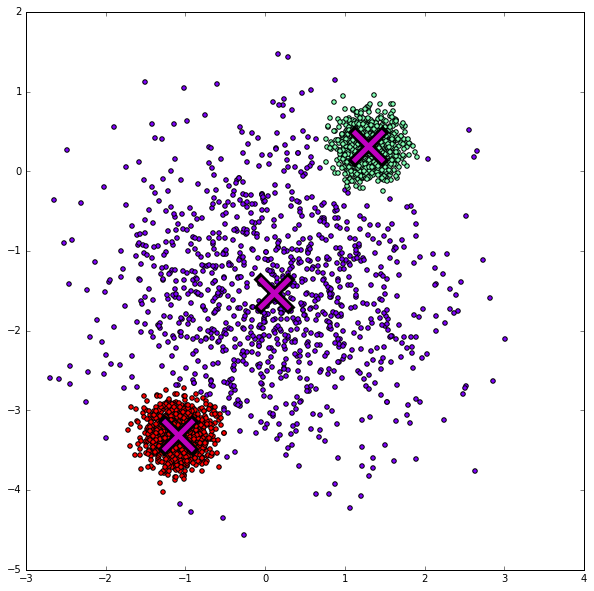

1.67046647668 1.52145214521 236.144


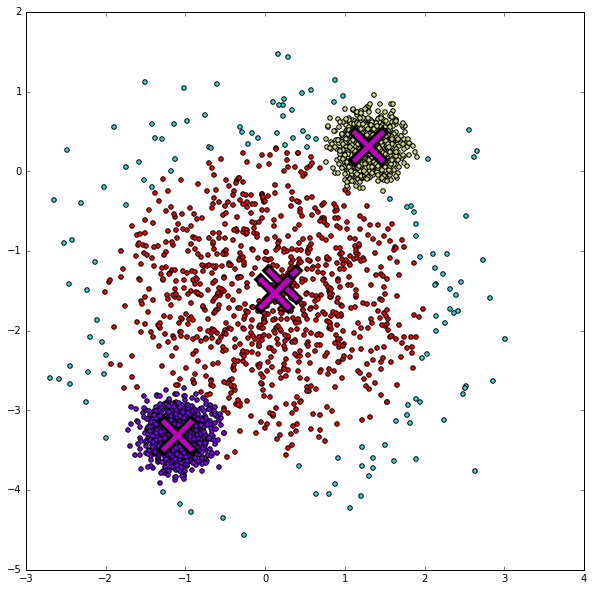

In [11]:
for k in range(3,5):
    c_means, c_sigmas, c_pis, train_assignments, train_loss = mog_learning(data=train_2d, n_clusters=k, learning_rate=LR, num_epochs=n_epochs, show_loss = False)
    valid_assignments, valid_loss = mog_assignment(valid_2d, c_means, c_sigmas, c_pis)
    print valid_loss
    plot_clusters(valid_2d, c_means, valid_assignments)

1.31393430328 1.24602460246 205.821


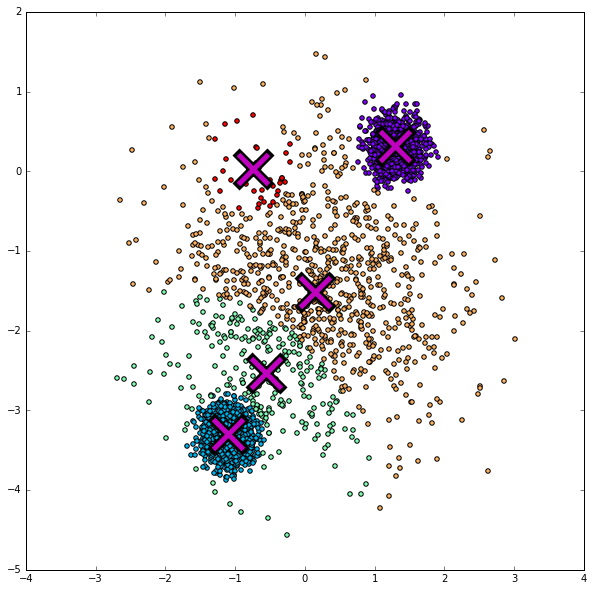

In [12]:
for k in range(5,6):
    c_means, c_sigmas, c_pis, train_assignments, train_loss = mog_learning(data=train_2d, n_clusters=k, learning_rate=LR, num_epochs=n_epochs, show_loss = False)
    valid_assignments, valid_loss = mog_assignment(valid_2d, c_means, c_sigmas, c_pis)
    print valid_loss
    plot_clusters(valid_2d, c_means, valid_assignments)

In [ ]:
# Part 2.2.4 
n_epochs=500
kmeans_learning(data=data100d, n_centroids=1, num_epochs=n_epochs, show_loss = False, give_histogram = True)
c_means4, c_sigmas4, c_pis4, train_assignments4, train_loss4 = mog_learning(data=data100d, n_clusters=1, learning_rate=LR, num_epochs=200, show_loss = False)


In [ ]:
c_means4, c_sigmas4, c_pis4

In [ ]:
# Part 2.2.4
for k in range(1, 10):
    c_centroids, train_assignments, KMEANS_loss, hist = kmeans_learning(data=data100d, n_centroids=k, num_epochs=n_epochs, show_loss = False, give_histogram = True)
    c_means, c_sigmas, c_pis, train_assignments, MOG_loss = mog_learning(data=data100d, n_clusters=k, learning_rate=LR, num_epochs=200, show_loss = False)
    print k, "Clusters - KMeans Loss:", KMEANS_loss, "MOG Loss:", MOG_loss

In [ ]:
c_centroids, train_assignments, KMEANS_loss, hist = kmeans_learning(data=data100d, n_centroids=5, num_epochs=200, show_loss = False, give_histogram = True)
c_means, c_sigmas, c_pis, train_assignments, MOG_loss = mog_learning(data=data100d, n_clusters=5, learning_rate=LR, num_epochs=200, show_loss = False)
print "At 5 Clusters - KMeans Loss:", KMEANS_loss, "MOG Loss:", MOG_loss
print "Vars and pis:" c_sigmas, c_pis